In [0]:
import tensorflow as tf
import os

from tensorflow.python.keras.datasets import cifar10
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.python.keras.utils import to_categorical

import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
(X_train, Y_train), (X_test, y_test) = cifar10.load_data()
X_train.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

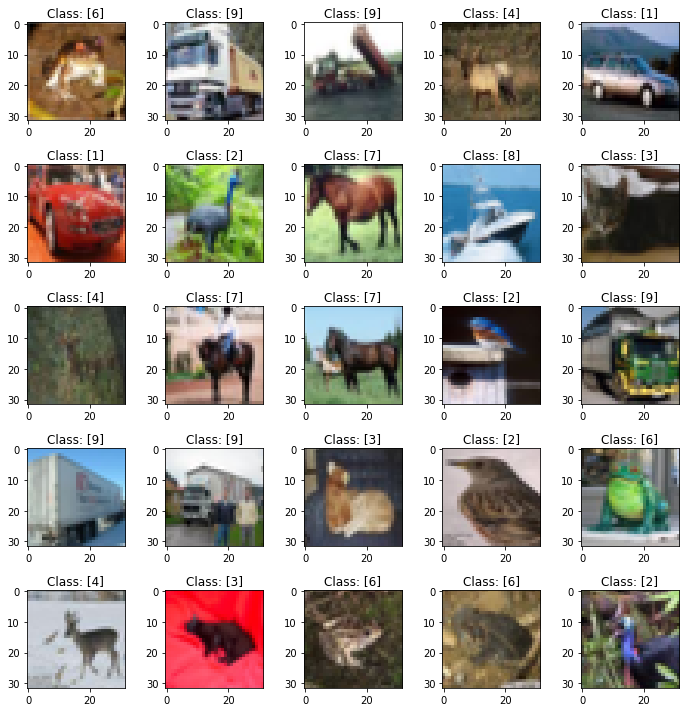

In [0]:
plt.figure(figsize=(10,10))
for idx in range(25):
    plt.subplot(5,5,idx+1)
    plt.imshow(X_train[idx], cmap='gray')
    plt.title('Class: {}'.format(Y_train[idx]))
    plt.tight_layout()

In [0]:
img_rows, img_cols = X_train.shape[1], X_train.shape[2]

num_channels = 3
X_train = X_train.reshape(-1, img_rows, img_cols, num_channels)
X_test = X_test.reshape(-1, img_rows, img_cols, num_channels)

input_shape = (img_rows, img_cols, num_channels)

X_train.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [0]:
if np.max(X_train) >1: X_train = X_train / 255
if np.max(X_test) >1: X_test = X_test / 255

In [0]:
if len(Y_train.shape) == 2:
    Y_train = Y_train.reshape(-1)
    y_test = y_test.reshape(-1)
    
if len(Y_train.shape) == 1:
    num_classes = len(set(Y_train))
    Y_train = to_categorical(Y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)
Y_train.shape, y_test.shape

((50000, 10), (10000, 10))

In [0]:

resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_host(resolver.master())
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)
with strategy.scope():
  model = Sequential([
    Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = input_shape),
    Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'),
    MaxPool2D(pool_size = (2, 2)),
    Dropout(0.25),
    
    
    Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'),
    Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'),
    MaxPool2D(pool_size = (2, 2)),
    Dropout(0.25),

    Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'),
    MaxPool2D(pool_size = (2, 2)),
    Dropout(0.25),
    
    Flatten(),
    
    Dense(1024, activation = 'relu'),
    Dropout(0.5),
    Dense(num_classes, activation = 'softmax')
])
  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  model.fit(
    X_train, Y_train,
    batch_size=128*8,
    steps_per_epoch=48,
    epochs=20)

W0702 19:00:20.925866 140590288820096 tpu_strategy_util.py:56] TPU system %s has already been initialized. Reinitializing the TPU can cause previously created variables on TPU to be lost.
I0702 19:00:20.927382 140590288820096 tpu_strategy_util.py:60] Initializing the TPU system.
I0702 19:00:28.306016 140590288820096 tpu_strategy_util.py:94] Finished initializing TPU system.
I0702 19:00:28.308389 140590288820096 tpu_system_metadata.py:78] Querying Tensorflow master (grpc://10.114.24.34:8470) for TPU system metadata.
I0702 19:00:28.322482 140590288820096 tpu_system_metadata.py:148] Found TPU system:
I0702 19:00:28.324345 140590288820096 tpu_system_metadata.py:149] *** Num TPU Cores: 8
I0702 19:00:28.325406 140590288820096 tpu_system_metadata.py:150] *** Num TPU Workers: 1
I0702 19:00:28.326550 140590288820096 tpu_system_metadata.py:152] *** Num TPU Cores Per Worker: 8
I0702 19:00:28.327413 140590288820096 tpu_system_metadata.py:154] *** Available Device: _DeviceAttributes(/job:worker/rep

InvalidArgumentError: ignored

In [0]:
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
tf.logging.set_verbosity(tf.logging.INFO)

In [0]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
  model,
  strategy = tf.contrib.tpu.TPUDistributionStrategy(
    tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

W0702 18:49:14.162373 140590288820096 keras_support.py:217] Keras support is now deprecated in support of TPU Strategy. Please follow the distribution strategy guide on tensorflow.org to migrate to the 2.0 supported version.
I0702 18:49:14.164123 140590288820096 tpu_system_metadata.py:78] Querying Tensorflow master (grpc://10.114.24.34:8470) for TPU system metadata.
I0702 18:49:14.178539 140590288820096 tpu_system_metadata.py:148] Found TPU system:
I0702 18:49:14.181459 140590288820096 tpu_system_metadata.py:149] *** Num TPU Cores: 8
I0702 18:49:14.182487 140590288820096 tpu_system_metadata.py:150] *** Num TPU Workers: 1
I0702 18:49:14.183561 140590288820096 tpu_system_metadata.py:152] *** Num TPU Cores Per Worker: 8
I0702 18:49:14.184624 140590288820096 tpu_system_metadata.py:154] *** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 4561244012497545795)
I0702 18:49:14.185632 140590288820096 tpu_system_metadata.py:154] *** Available Device: _Devic

AttributeError: ignored

In [0]:
model.evaluate(X_test, y_test)